In [12]:
import pandas  as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler


In [13]:
df = pd.read_csv('cardio.csv', sep=';')

In [14]:
df.info
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [15]:
df = df.drop(columns=["id"], errors="ignore")

In [16]:
df = df.drop_duplicates().reset_index(drop=True)

In [17]:
df["age_year"] = (df["age"] / 365.25).round(0)

In [18]:
df["BMI"] = df["weight"] / (df["height"]/100) ** 2

In [19]:
bp_mask = (
    (df["ap_lo"] < df["ap_hi"]) &
    df["ap_hi"].between(80, 250) &
    df["ap_lo"].between(40, 150)
)
bmi_mask = df["BMI"].between(10, 60)
age_mask = df["age_year"].between(18, 90)

df = df[bp_mask & bmi_mask & age_mask].reset_index(drop=True)

In [20]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_year', 'BMI'],
      dtype='object')

In [21]:
features = ['gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_year', 'BMI', ]

In [22]:

import matplotlib.pyplot as plt
import seaborn as sns


# Descriptive Statistics and Data Inspection

In [23]:

# Display descriptive statistics
print("Descriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Value counts for categorical variables
categorical_vars = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
for var in categorical_vars:
    print(f"\nValue counts for {var}:")
    print(df[var].value_counts())

# Data types
print("\nData Types:")
print(df.dtypes)


Descriptive Statistics:
                age        gender        height        weight         ap_hi  \
count  68572.000000  68572.000000  68572.000000  68572.000000  68572.000000   
mean   19464.658155      1.348772    164.409817     74.090152    126.672184   
std     2468.021451      0.476585      7.942599     14.214334     16.671654   
min    10798.000000      1.000000    100.000000     28.000000     80.000000   
25%    17658.000000      1.000000    159.000000     65.000000    120.000000   
50%    19701.000000      1.000000    165.000000     72.000000    120.000000   
75%    21324.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000    240.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  68572.000000  68572.000000  68572.000000  68572.000000  68572.000000   
mean      81.302587      1.364901      1.225821      0.087995      0.053345   
std        9.419338      0.

# Univariate Analysis Visualizations

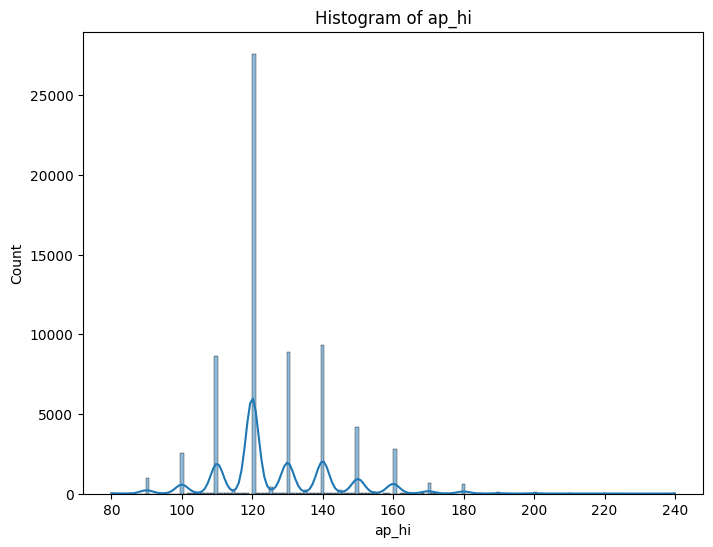

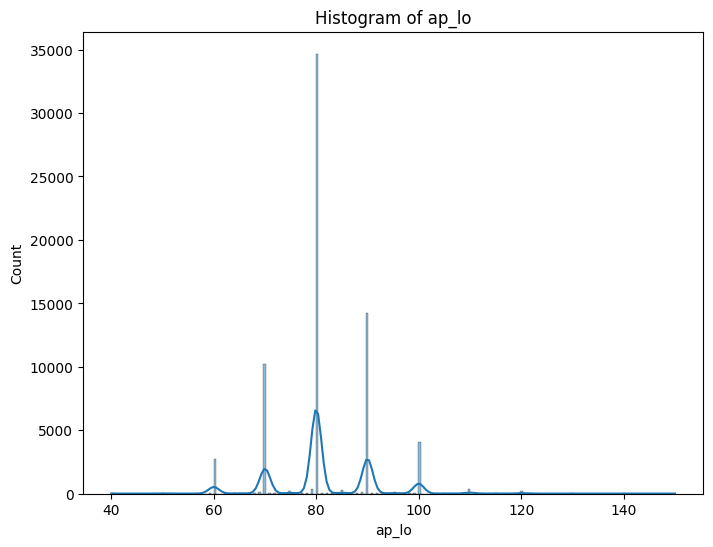

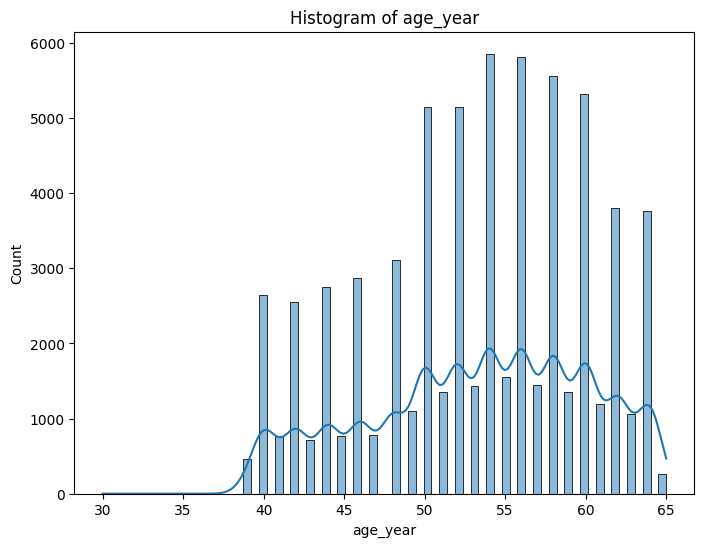

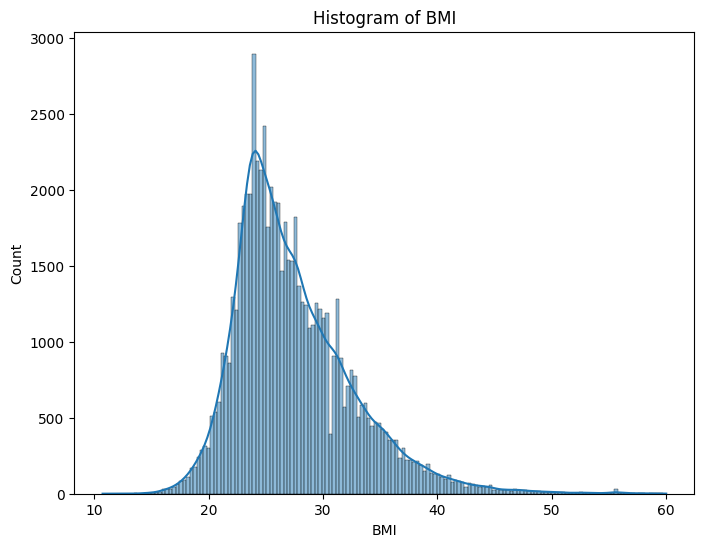

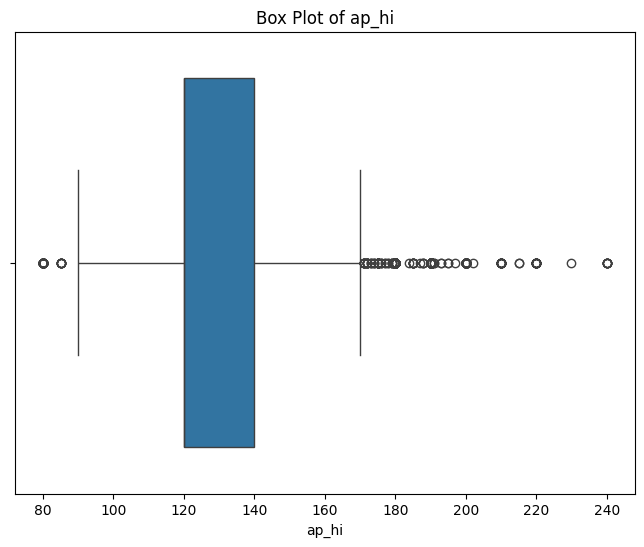

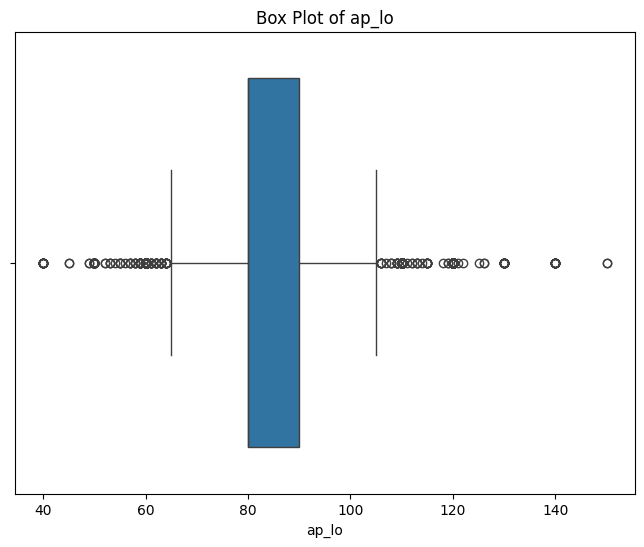

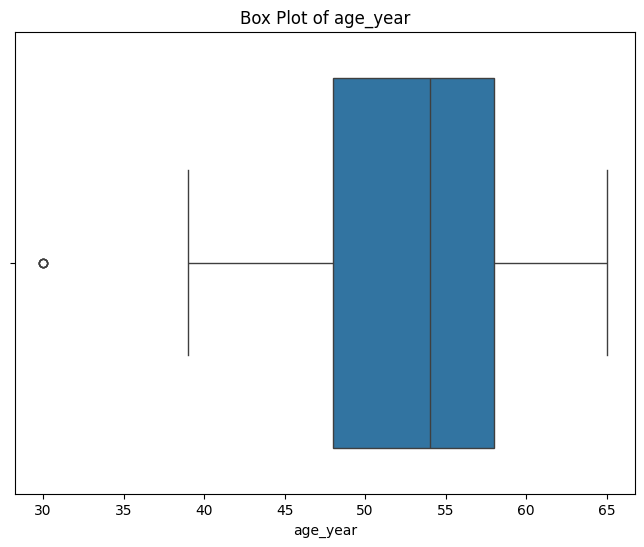

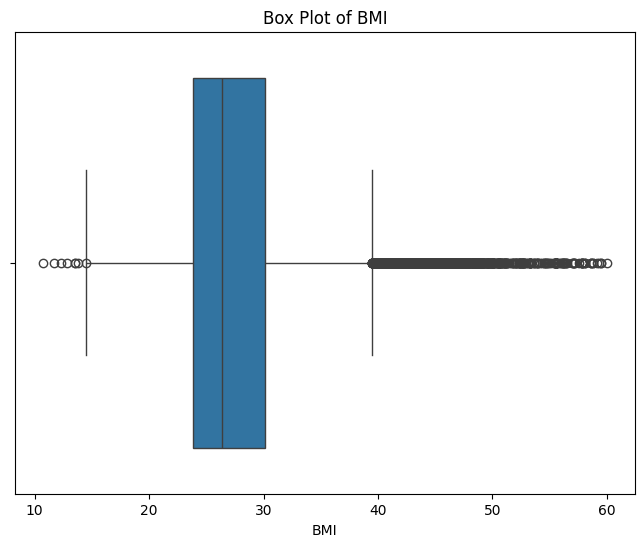

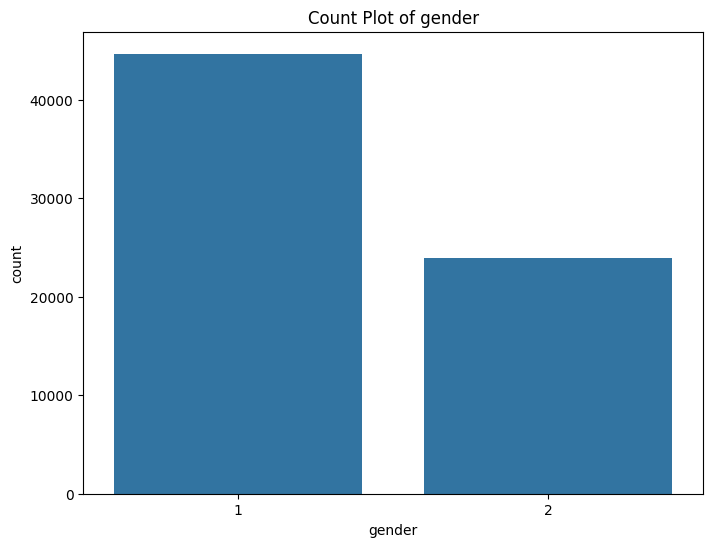

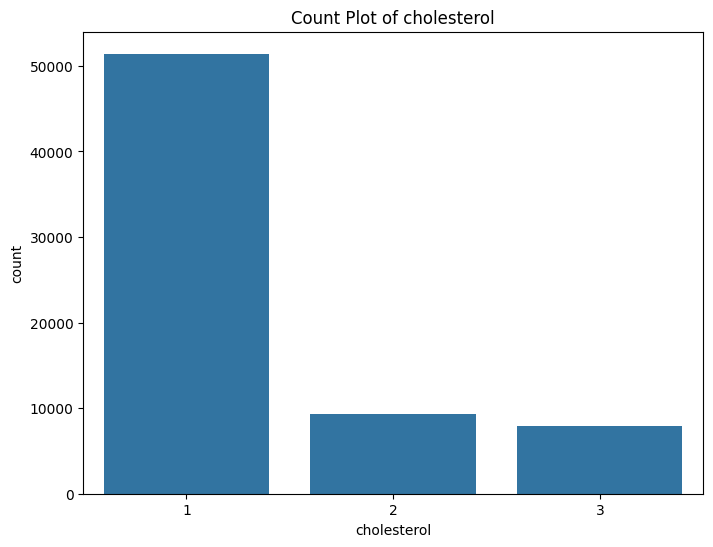

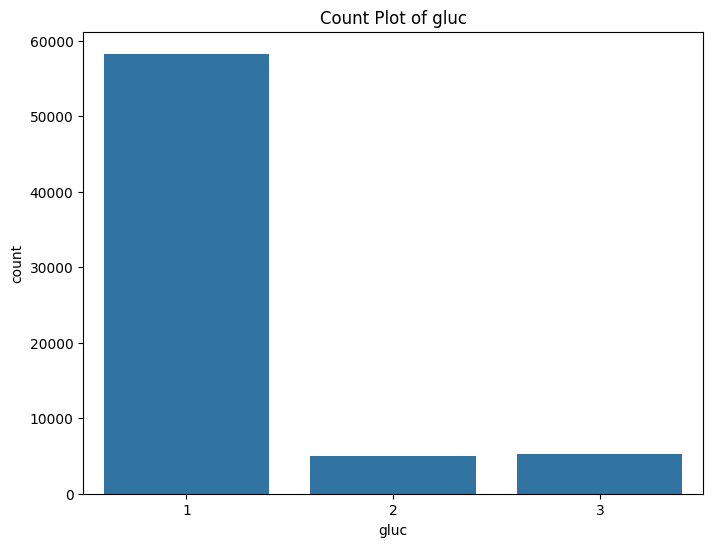

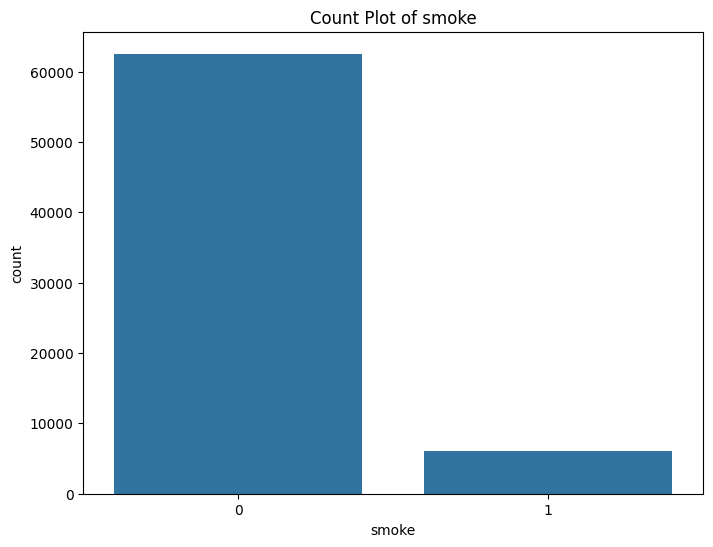

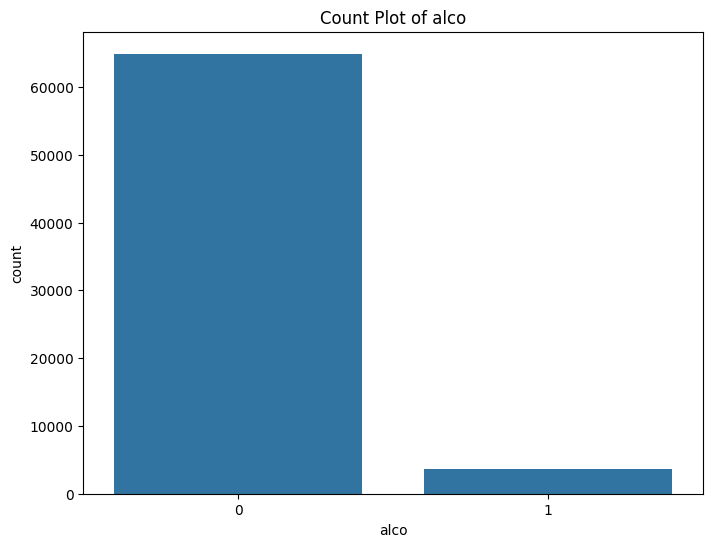

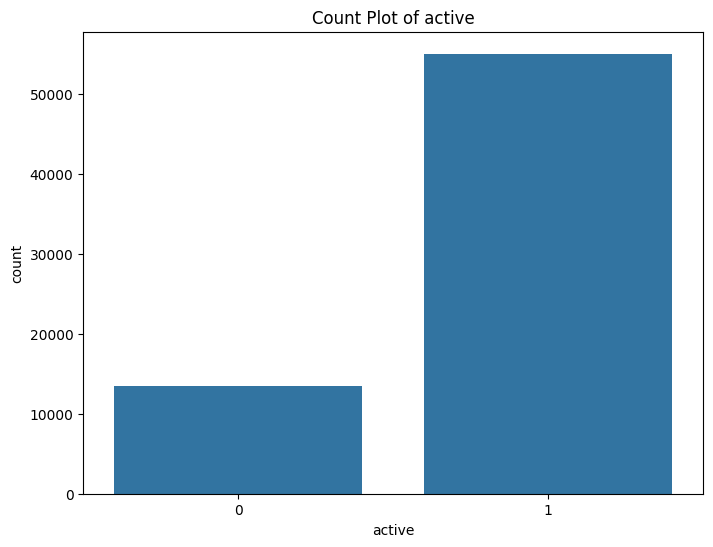

In [24]:

# Histograms for numerical features
numerical_vars = ['ap_hi', 'ap_lo', 'age_year', 'BMI']
for var in numerical_vars:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[var], kde=True)
    plt.title(f'Histogram of {var}')
    plt.show()

# Box plots for outliers
for var in numerical_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[var])
    plt.title(f'Box Plot of {var}')
    plt.show()

# Count plots for categorical features
for var in categorical_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[var])
    plt.title(f'Count Plot of {var}')
    plt.show()


# Bivariate and Multivariate Analysis

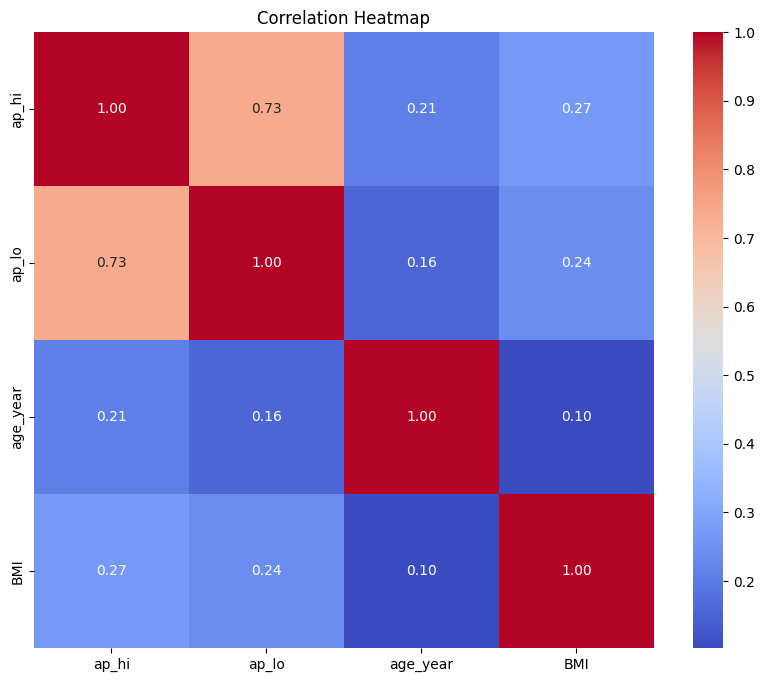

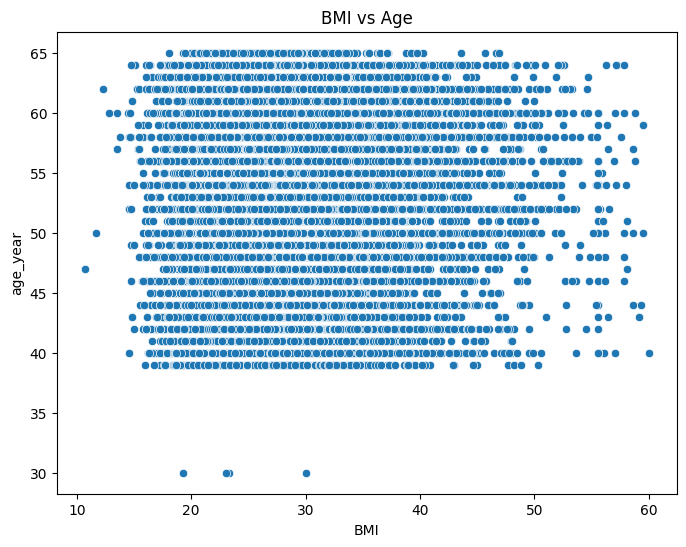

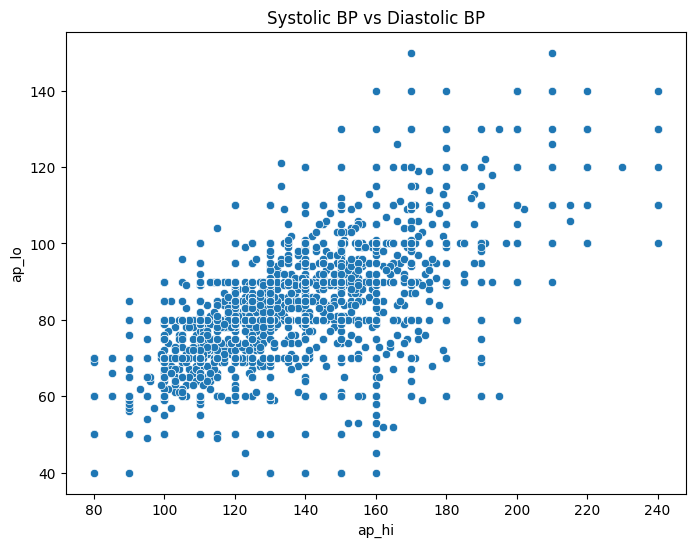

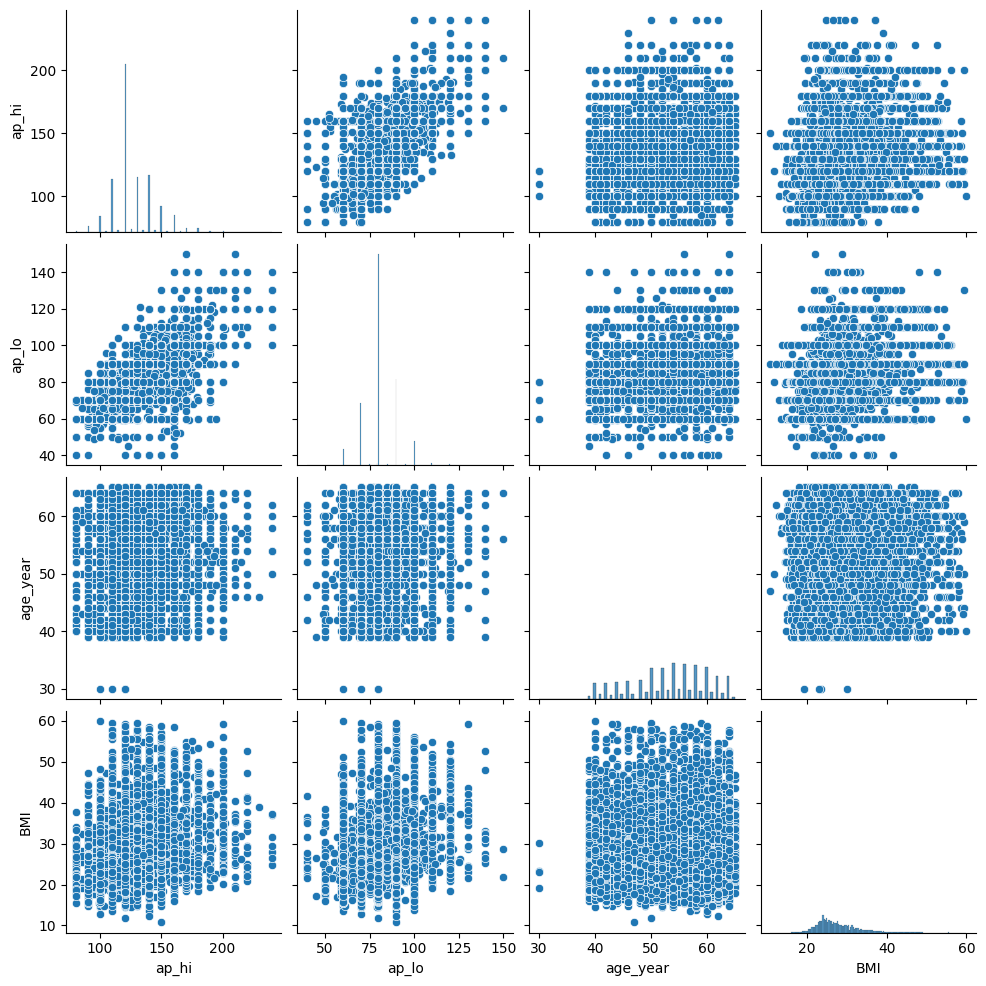

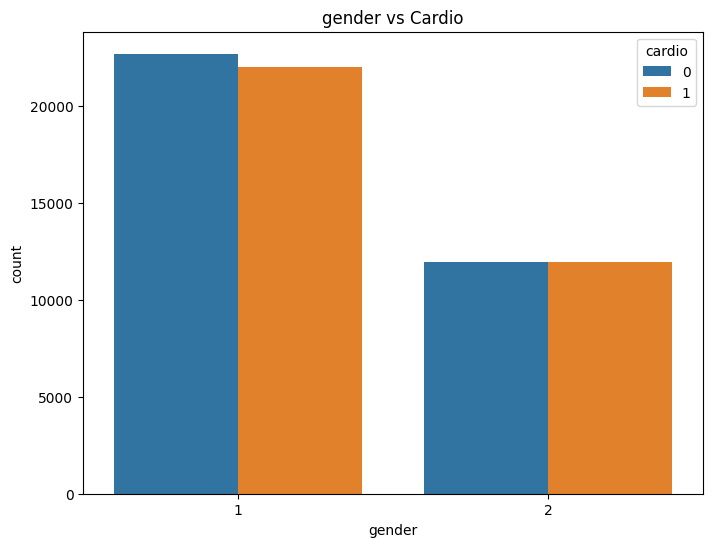

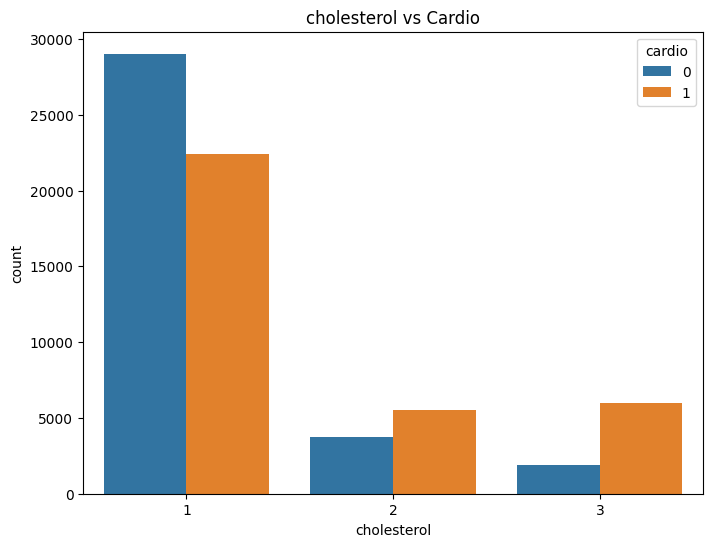

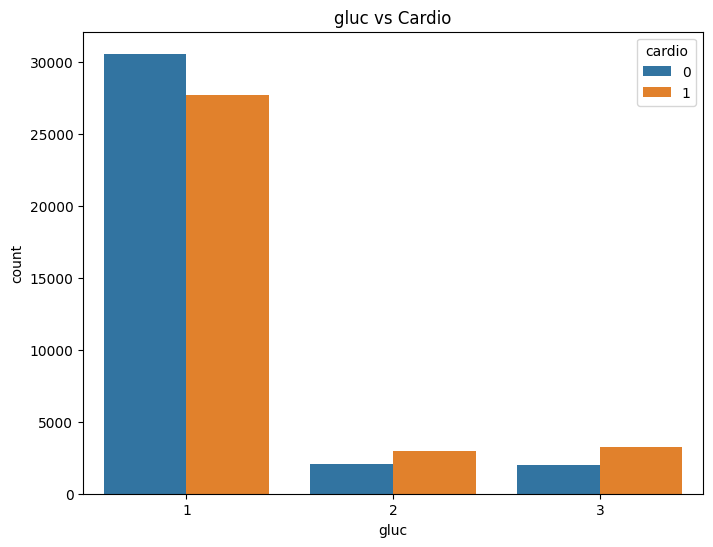

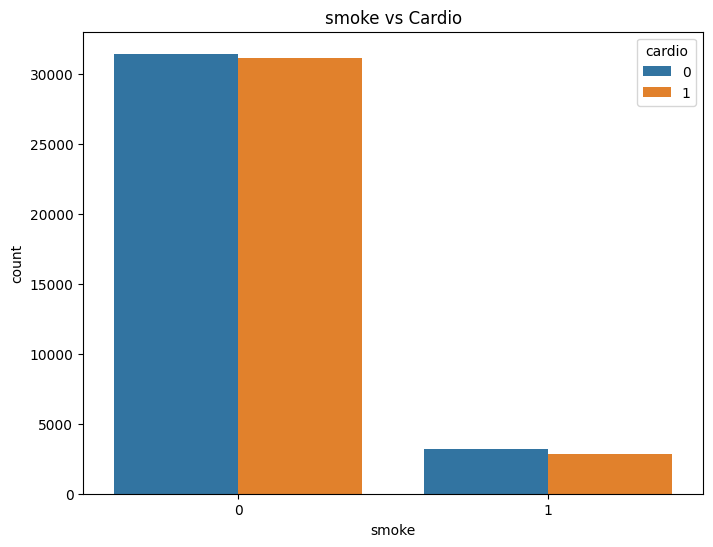

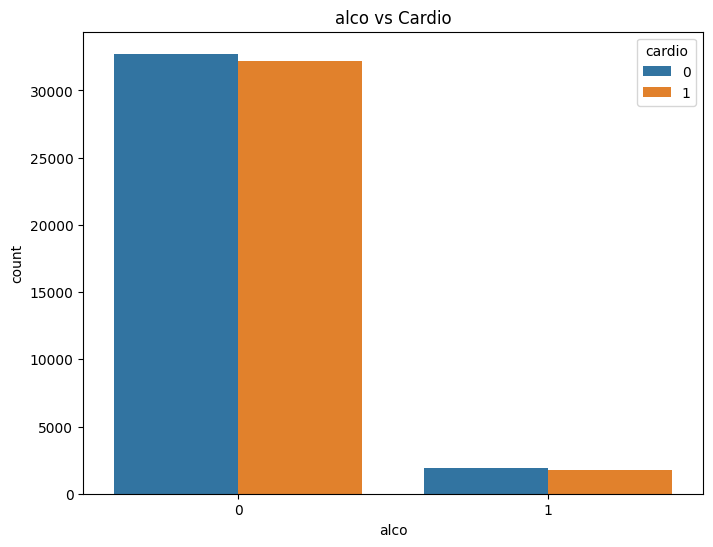

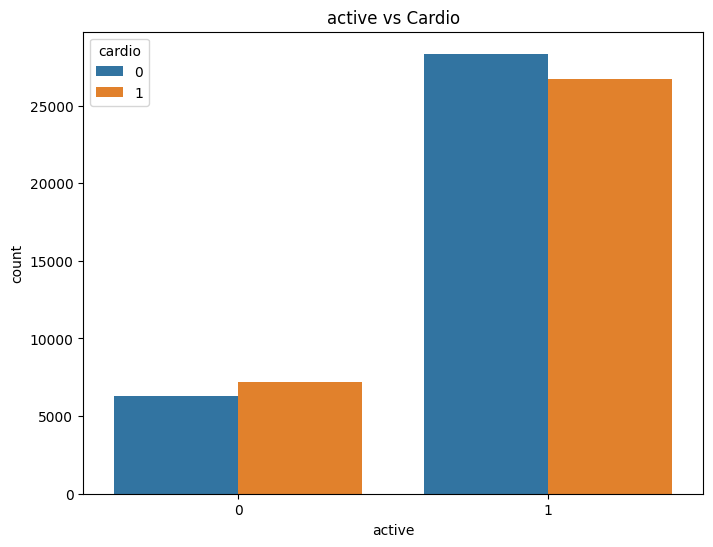

In [25]:

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
corr = df[numerical_vars].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots
plt.figure(figsize=(8, 6))
sns.scatterplot(x='BMI', y='age_year', data=df)
plt.title('BMI vs Age')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='ap_hi', y='ap_lo', data=df)
plt.title('Systolic BP vs Diastolic BP')
plt.show()

# Pair plot
sns.pairplot(df[numerical_vars])
plt.show()

# Cross-tabulations or bar plots for categorical vs target
for var in categorical_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=var, hue='cardio', data=df)
    plt.title(f'{var} vs Cardio')
    plt.show()


# Target Variable Analysis

Value counts for cardio:
cardio
0    34642
1    33930
Name: count, dtype: int64


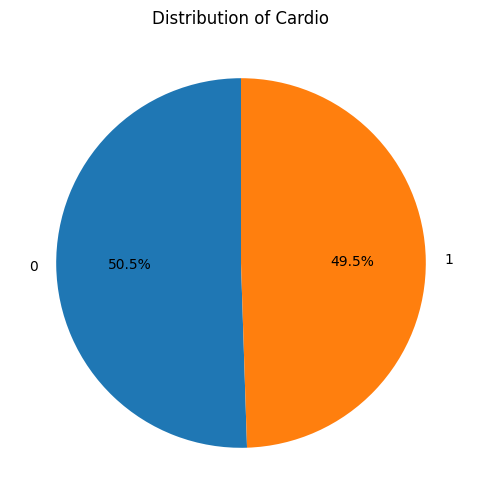

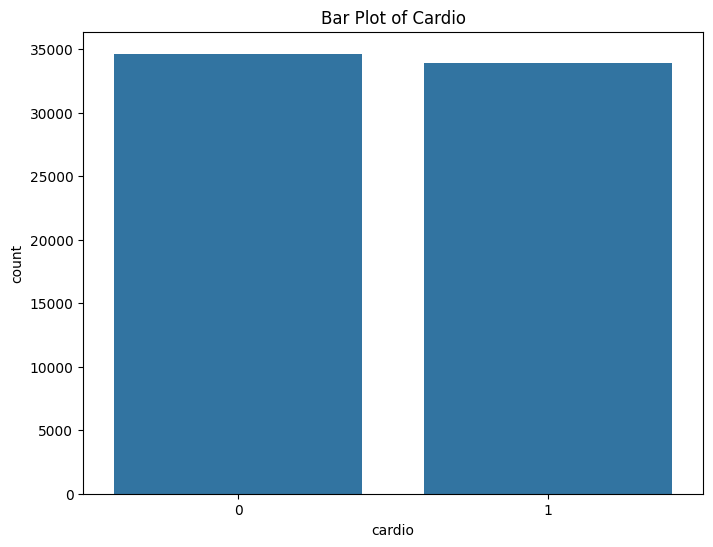

In [26]:

# Distribution of 'cardio'
print("Value counts for cardio:")
print(df['cardio'].value_counts())

# Pie chart
plt.figure(figsize=(8, 6))
df['cardio'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Cardio')
plt.ylabel('')
plt.show()

# Bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='cardio', data=df)
plt.title('Bar Plot of Cardio')
plt.show()


# Enhanced Outlier Detection

Outliers in ap_hi: 996


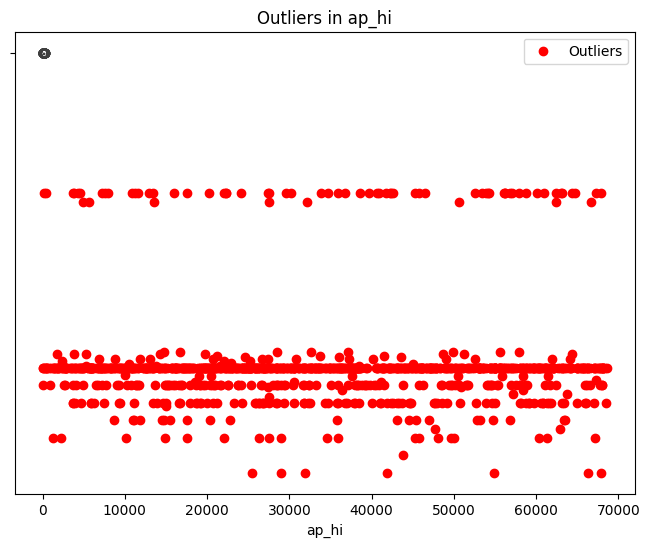

Outliers in ap_lo: 3491


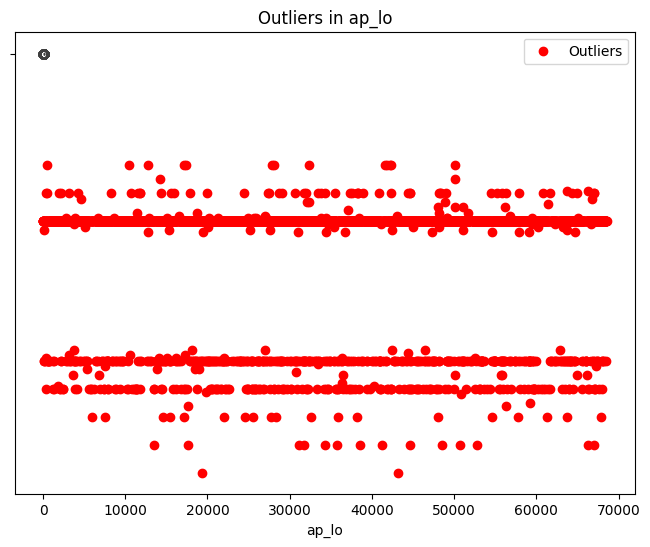

Outliers in age_year: 4


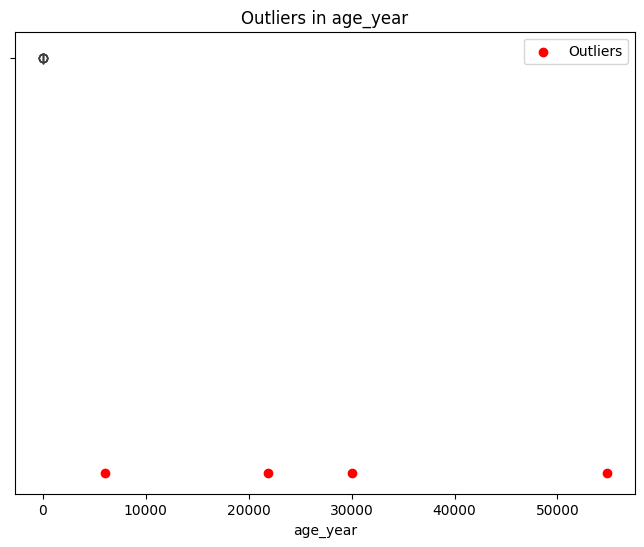

Outliers in BMI: 1958


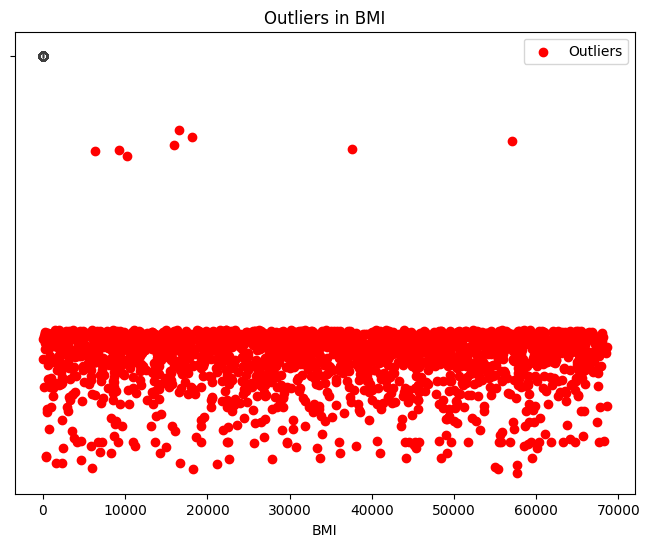

In [27]:

# IQR-based outlier detection
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

for var in numerical_vars:
    outliers = detect_outliers_iqr(df, var)
    print(f"Outliers in {var}: {len(outliers)}")
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[var])
    plt.scatter(outliers.index, outliers[var], color='red', label='Outliers')
    plt.title(f'Outliers in {var}')
    plt.legend()
    plt.show()


# Data Quality Checks and Categorical Handling

In [28]:

# Ensure data types are correct
print("Data Types:")
print(df.dtypes)

# Convert categorical variables to category type
categorical_vars = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
for var in categorical_vars:
    df[var] = df[var].astype('category')

print("\nUpdated Data Types:")
print(df.dtypes)

# Check for any remaining inconsistencies
print("\nUnique values in categorical variables:")
for var in categorical_vars:
    print(f"{var}: {df[var].unique()}")


Data Types:
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
age_year       float64
BMI            float64
dtype: object

Updated Data Types:
age               int64
gender         category
height            int64
weight          float64
ap_hi             int64
ap_lo             int64
cholesterol    category
gluc           category
smoke          category
alco           category
active         category
cardio            int64
age_year        float64
BMI             float64
dtype: object

Unique values in categorical variables:
gender: [2, 1]
Categories (2, int64): [1, 2]
cholesterol: [1, 3, 2]
Categories (3, int64): [1, 2, 3]
gluc: [1, 2, 3]
Categories (3, int64): [1, 2, 3]
smoke: [0, 1]
Categories (2, int64): [0, 1]
alco: [0, 1]
Categories (2, int64): [0, 1]
act

# Summary Insights


## Key Findings:
- [Add key findings here based on analysis]

## Insights:
- [Add insights here]

## Next Steps for Modeling:
- [Add next steps here]
